In [19]:
# Work with paths
import os
import sys
sys.path.append('..')

# import implemented modules
from src.models import tree
import src.config as cfg
# from src.data import make_dataset
# import src.utils as utils
# from src.visualization import visualize
# from src.features import features

# import other modules
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from catboost import CatBoostRegressor, metrics, Pool
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer



# Generate Dataset

In [20]:
! python3 ../src/data/make_dataset.py                           \
    --input_filepath=../data/raw/train.csv                      \
    --output_data_filepath=../data/processed/train_data.pkl     \
    --output_encoder_filepath=../data/processed/transformer.pkl

2022-10-22 20:19:33,530 - __main__ - INFO - making final data set from raw data
2022-10-22 20:19:33,659 - __main__ - INFO - Dataset saved to ../data/processed/train_data.pkl


In [21]:
! python3 ../src/data/make_dataset.py                           \
    --input_filepath=../data/raw/test.csv                       \
    --output_data_filepath=../data/processed/val_data.pkl       \
    --is_val=True                                               \
    --output_encoder_filepath=../data/processed/transformer.pkl

2022-10-22 20:19:36,387 - __main__ - INFO - making final data set from raw data
2022-10-22 20:19:36,493 - __main__ - INFO - Dataset saved to ../data/processed/val_data.pkl


None

Load dataset

In [22]:
train_data  = pd.read_pickle(str(os.getcwd() + "/../data/processed/train_data.pkl"))

val_data   = pd.read_pickle(str(os.getcwd() + "/../data/processed/val_data.pkl"))

Visualize data

If we want to predict illness, we are interested not in getting FalseNegative that is why main function is Recall

$$\text{Recall}=\frac{TP}{TP+FN}$$

Generate tran and test selections

In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(
                                                    train_data[:,:-1],
                                                    train_data[:,-1],
                                                    train_size=0.8,
                                                    random_state=cfg.RANDOM_STATE,
                                                    )

Catboost

In [9]:
train_pool = Pool(X_train, Y_train)
test_pool  = Pool(X_test, Y_test)

model = CatBoostClassifier(
    iterations=1000, 
    loss_function='MultiLogloss', 
    eval_metric='MultiLogloss',
    learning_rate=0.01,
    bootstrap_type='Bayesian', 
    boost_from_average=False,
    leaf_estimation_iterations=10, 
    leaf_estimation_method='Gradient', 
    custom_metric=['Recall', 'Precision', 'F1'],
    random_seed=cfg.RANDOM_STATE,
    task_type='CPU',
    devices='0:1',
)

model.fit(train_pool, 
        eval_set=test_pool, 
        metric_period=10, 
        plot=True, 
        verbose=True, 
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6871650	test: 0.6873138	best: 0.6873138 (0)	total: 63.6ms	remaining: 1m 3s
10:	learn: 0.6328486	test: 0.6347692	best: 0.6347692 (10)	total: 104ms	remaining: 9.32s
20:	learn: 0.5874997	test: 0.5906362	best: 0.5906362 (20)	total: 144ms	remaining: 6.71s
30:	learn: 0.5483113	test: 0.5528230	best: 0.5528230 (30)	total: 184ms	remaining: 5.75s
40:	learn: 0.5160768	test: 0.5218888	best: 0.5218888 (40)	total: 224ms	remaining: 5.24s
50:	learn: 0.4889029	test: 0.4958552	best: 0.4958552 (50)	total: 267ms	remaining: 4.96s
60:	learn: 0.4658248	test: 0.4738023	best: 0.4738023 (60)	total: 309ms	remaining: 4.76s
70:	learn: 0.4459481	test: 0.4550275	best: 0.4550275 (70)	total: 354ms	remaining: 4.63s
80:	learn: 0.4291530	test: 0.4391585	best: 0.4391585 (80)	total: 399ms	remaining: 4.52s
90:	learn: 0.4153198	test: 0.4262856	best: 0.4262856 (90)	total: 441ms	remaining: 4.4s
100:	learn: 0.4033556	test: 0.4152371	best: 0.4152371 (100)	total: 485ms	remaining: 4.31s
110:	learn: 0.3927692	test: 0.40

In [21]:
model.best_score_.get('validation')

{'Precision:class=3': 1.0,
 'Recall:class=3': 0.05555555555555555,
 'F1:class=2': 0.0909090909090909,
 'F1:class=0': 0.7628865979381443,
 'Recall:class=0': 0.872093023255814,
 'Precision:class=1': 1.0,
 'Recall:class=2': 0.047619047619047616,
 'Precision:class=4': 1.0,
 'Precision:class=2': 1.0,
 'F1:class=3': 0.10526315789473684,
 'Precision:class=0': 0.6914893617021277,
 'Recall:class=1': 0.0,
 'Recall:class=4': 0.0,
 'F1:class=4': 0.0,
 'F1:class=1': 0.0,
 'MultiLogloss': 0.33056214031295184}

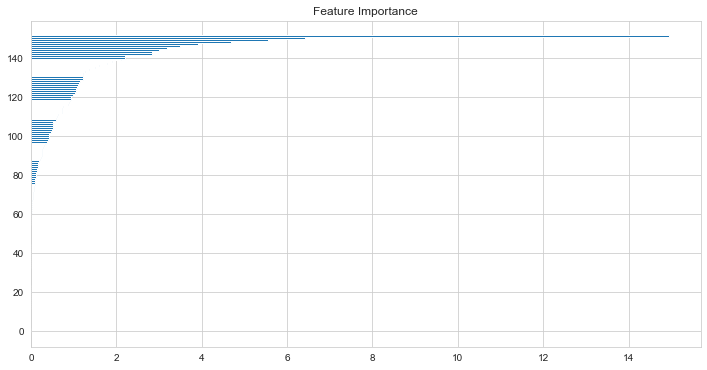

In [11]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.title('Feature Importance')
plt.show()

Metrics

In [12]:
Y_real = Y_test
Y_pred = np.array(model.predict(X_test), dtype=np.int8)

print(f"Accuracy: {accuracy_score(Y_pred, Y_real)}")
print(f"Recall: {recall_score(Y_real, Y_pred, average=None, zero_division=0)}")
print(f"AUC: {roc_auc_score(Y_real, Y_pred, average=None)}")

utils.save_model(model, str(os.getcwd() + "/../data/interim/CatboostClassifier.pkl"))

Accuracy: 0.5392670157068062
Recall: [0.80232558 0.         0.         0.         0.        ]
AUC: [0.74401993 0.5        0.5        0.5        0.5       ]


Try to get better recall with desisionTreeClassifier

In [13]:
DesisionTree = tree.tree_pipe.fit(X_train, Y_train)

Y_real = Y_test
Y_pred = np.array(DesisionTree.predict(X_test), dtype=np.int8)

print(f"Accuracy: {accuracy_score(Y_pred, Y_real)}")
print(f"Recall: {recall_score(Y_real, Y_pred, average=None, zero_division=0)}")
print(f"AUC: {roc_auc_score(Y_real, Y_pred, average=None)}")

utils.save_model(DesisionTree, str(os.getcwd() + "/../data/interim/DesisionTree.pkl"))

Accuracy: 0.38219895287958117
Recall: [0.62790698 0.         0.04761905 0.         0.21052632]
AUC: [0.65681063 0.48333333 0.47380952 0.44219653 0.55584455]


Inference

In [19]:
np.array(DesisionTree.predict(Transformer.transform(val_data)), dtype=np.int8)

array([[1, 0, 1, 1, 0],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=int8)

Tuning

In [ ]:
df = pd.concat([train_data, target_data], axis=1).copy()


from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error

kf = KFold(n_splits=3, shuffle=True)

DEFAULT_PARAMETERS = {'n_estimators' : 4500, 'learning_rate' : 0.1}
DEFAULT_MODEL_METRICS = {}


def score_catboost_model(df, catboost_parameters, update_defaults=False):
    r2_values = []
    rmse_values = []
    catboost_parameters.update(DEFAULT_PARAMETERS)
    for train_index, test_index in kf.split(df):
        train_pool = Pool(pd.DataFrame(Transformer.transform(df)[train_index, :-5]).T,
                          pd.DataFrame(Transformer.transform(df)[train_index, -5:]).T
        )

        test_pool = Pool(pd.DataFrame(Transformer.transform(df)[test_index, :-5]).T,
                         pd.DataFrame(Transformer.transform(df)[test_index, -5:]).T  
        )

        model = CatBoostClassifier(catboost_parameters)
        model.fit(train_pool, verbose=False)
        
        r2_values.append(r2_score(df.iloc[test_index].price_usd.values, model.predict(test_pool)))
        rmse_values.append(mean_squared_error(df.iloc[test_index].price_usd.values,
                                              model.predict(test_pool),
                                              squared=False)) 
    if update_defaults:
        DEFAULT_MODEL_METRICS['R2'] = np.mean(r2_values)
        DEFAULT_MODEL_METRICS['RMSE'] = np.mean(rmse_values)
        print('R2 score: {:.4f}({:.4f})'.format(np.mean(r2_values), np.std(r2_values)))
        print('RMSE score: {:.0f}({:.0f})'.format(np.mean(rmse_values), np.std(rmse_values)))  

    else:
        DEFAULT_MODEL_R2 = DEFAULT_MODEL_METRICS['R2']
        DEFAULT_MODEL_RMSE = DEFAULT_MODEL_METRICS['RMSE']
        r2_change = 100 * (np.mean(r2_values) - DEFAULT_MODEL_R2) / DEFAULT_MODEL_R2
        rmse_change = 100 * (np.mean(rmse_values) - DEFAULT_MODEL_RMSE) / DEFAULT_MODEL_RMSE
        print('R2 score: {:.4f}({:.4f}) {:+.1f}% compared to default parameters'.format(
            np.mean(r2_values), np.std(r2_values), r2_change))
        print('RMSE score: {:.0f}({:.0f}) {:+.1f}% compared to default parameters'.format(
            np.mean(rmse_values), np.std(rmse_values), rmse_change))  
        
    return model.get_all_params()


In [ ]:
model_params = score_catboost_model(train_data, {'model_size_reg': 0})